# Bayesian Beta Distributed Coin Inference

| | | |
|-|-|-|
|[ ![Creative Commons License](images/cc4.png)](http://creativecommons.org/licenses/by-nc/4.0/) |[ ![aGrUM](images/logoAgrum.png)](https://agrum.org) |[ ![interactive online version](images/atbinder.svg)](https://agrum.gitlab.io/extra/agrum_at_binder.html)

## build a fully bayesian beta distributed coin inference

This notebook is based on examples from Benjamin Datko (https://gist.github.com/bdatko).

The basic idea of this notebook is to show you could assess the probability for a coin, knowing a sequence of heads/tails.

In [1]:
import itertools
import time

from pylab import *
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb

In [2]:
gum.config["notebook","default_graph_size"]="12!"
gum.config["notebook","default_graph_inference_size"]="12!"

## Fill Beta parameters with a re-parameterization
* https://en.wikipedia.org/wiki/Beta_distribution

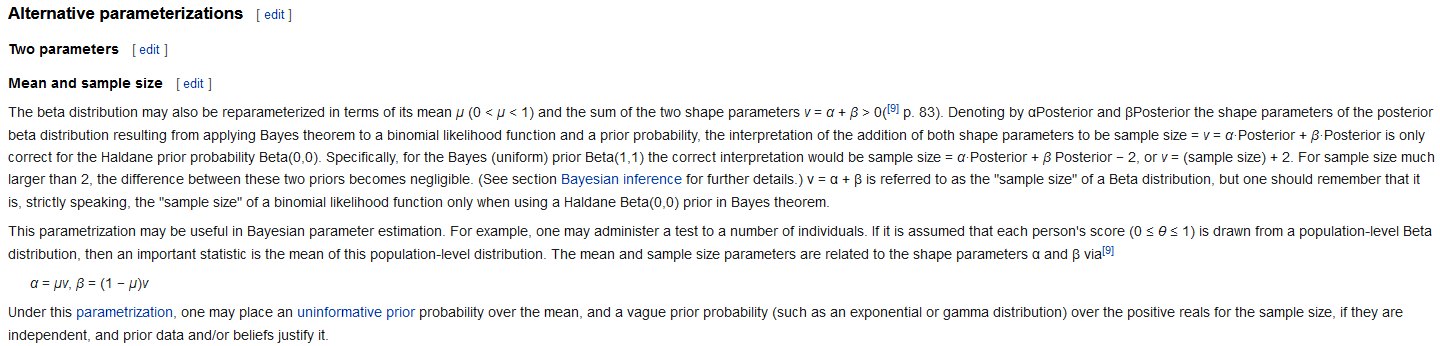

We propose a model where : mu and nu are the parameters of a beta which gives the distribution for the coins.

* below are some useful definitions
$$ \alpha = \mu \nu$$
$$ \beta = (1 - \mu) \nu $$

$$ \mu = \frac{\alpha}{\alpha + \beta} $$

* like in Wikipedia article, we will have a uniform prior on μ and an expoential prior on ν

In [3]:
# the sequence of COINS
serie=[1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,1]

In [4]:
def fillvect_(rv,vmin,vmax,size, **pdf_kwargs):
    x = linspace(vmin,vmax,size)
    pdf=rv.pdf(x, **pdf_kwargs)
    return x,pdf

def normalize_(rv,vmin,vmax,size, **pdf_kwargs):
    x = linspace(vmin,vmax,size)
    pdf=rv.pdf(x, **pdf_kwargs)
    return x,(pdf/sum(pdf))

In [5]:
NB_ = 300
vmin, vmax = 0.001, 0.999
pmin_mu, pmax_mu = 0.001, 0.999
pmin_nu, pmax_nu = 1,50
size_ = 16

In [6]:
bn=gum.BayesNet("SEQUENCE OF COINS MODEL")
mu = bn.add(gum.NumericalDiscreteVariable("mu","mean of the Beta distribution",0,1,NB_))
nu = bn.add(gum.NumericalDiscreteVariable("nu","'sample size' of the Beta where nu = a + b > 0",0,50,NB_))
bias=bn.add(gum.NumericalDiscreteVariable("bias","The bias of the coin",0,1,NB_))
hs=[bn.add(gum.LabelizedVariable(f"H{i}","The hallucinations of coin flips",2)) for i in range(size_)]

bn.addArc(mu,bias)
bn.addArc(nu,bias)
for h in hs:
    bn.addArc(bias,h)
print(bn)
bn

BN{nodes: 19, arcs: 18, domainSize: 10^12.2478, dim: 26915398, mem: 206Mo 73Ko 192o}


(pyAgrum.BayesNet<double>@0x121cd9600) BN{nodes: 19, arcs: 18, domainSize: 10^12.2478, dim: 26915398, mem: 206Mo 73Ko 192o}


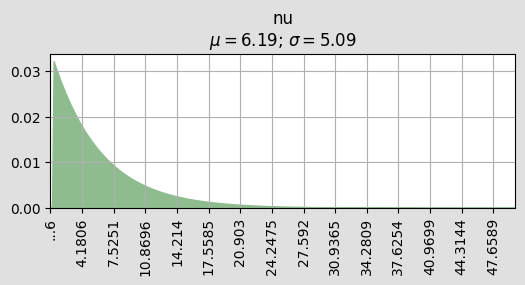
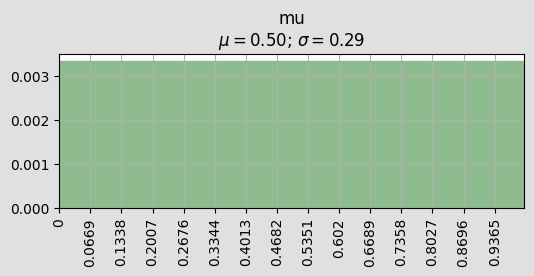

In [7]:
loc_, scale_ = 2, 5
x_nu, y_nu = normalize_(scipy.stats.expon,pmin_nu,pmax_nu,NB_,loc=loc_, scale=scale_)
x_mu, y_mu = normalize_(scipy.stats.uniform,pmin_mu,pmax_mu,NB_,)

bn.cpt(mu)[:] = y_mu # uniform prior for hyperparameter
bn.cpt(nu)[:] = y_nu # expoential prior for hyperparameter

gnb.flow.clear()
gnb.flow.add(gnb.getProba(bn.cpt(nu)),caption="Distribution for nu")
gnb.flow.add(gnb.getProba(bn.cpt(mu)),caption="Distribution for mu")
gnb.flow.display()             

In [8]:
# https://scicomp.stackexchange.com/a/10800
al_ = (x_mu[:,newaxis] * x_nu[newaxis,:])
be_ = (1 - x_mu)[:,newaxis] * x_nu[newaxis,:]

t_start = time.time()
pdf = scipy.stats.beta(al_,be_).pdf(linspace(vmin, vmax,NB_)[:,newaxis, newaxis])
bn.cpt("bias").fillWith(np.swapaxes(pdf, 0, -1).flatten())
bn.cpt("bias").normalizeAsCPT()
end_time = time.time() - t_start
print(f"Filling {NB_}^3 parameters in {end_time:5.3f}s")

Filling 300^3 parameters in 3.652s


In [9]:
x_bias = linspace(vmin, vmax, NB_)
x_hs = np.array([1 - x_bias, x_bias]).T
for h in hs:
    bn.cpt(h).fillWith(x_hs.flatten()).normalizeAsCPT()

## Evidence without evidence

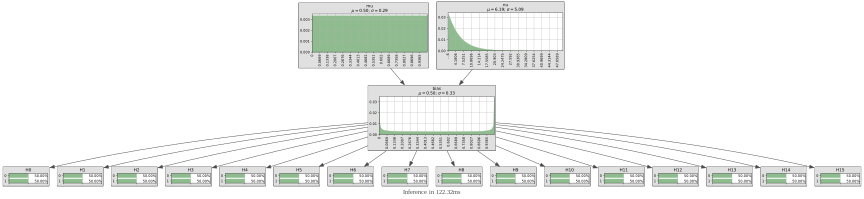

In [10]:
gnb.showInference(bn)

## Evidence with the sequence 

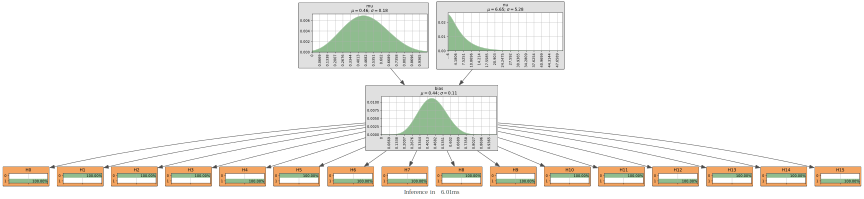

In [11]:
coin_evidence={f"H{i}":serie[i] for i in range(len(serie))}

gnb.showInference(bn,evs=coin_evidence)

In [12]:
ie=gum.LazyPropagation(bn)
ie.setEvidence(coin_evidence)
ie.makeInference()

In [13]:
from scipy.ndimage import center_of_mass

idx, _ = ie.posterior('bias').argmax()
map_bias = x_bias[idx[0]["bias"]]
idx, _ = ie.posterior('mu').argmax()
map_mu = x_mu[idx[0]["mu"]]
com = center_of_mass(ie.posterior('nu').toarray())[0]

print(f"MAP for mu : {map_mu}")
print(f"center of mass for nu : {com}")
print(f"MAP for bias : {map_bias}")

MAP for mu : 0.4449264214046823
center of mass for nu : 39.75304603040276
MAP for bias : 0.4382508361204014


## Smaller serie

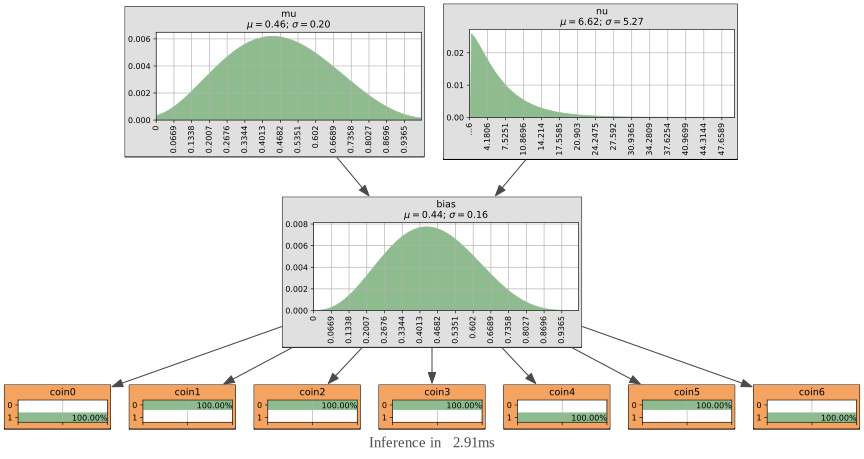

In [14]:
# With a smaller serie
serie=[1,0,0,0,1,0,1,]

bn=gum.BayesNet("SEQUENCE OF COINS MODEL")
mu = bn.add(gum.NumericalDiscreteVariable("mu","mean of the Beta distribution",0,1,NB_))
nu = bn.add(gum.NumericalDiscreteVariable("nu","'sample size' of the Beta where nu = a + b > 0",0,50,NB_))
bias=bn.add(gum.NumericalDiscreteVariable("bias","The bias of the coin",0,1,NB_))
hs=[bn.add(gum.LabelizedVariable(f"coin{i}","The hallucinations of coin flips",2)) for i in range(len(serie))]

bn.addArc(mu,bias)
bn.addArc(nu,bias)
for h in hs:
    bn.addArc(bias,h)
bn.cpt(mu)[:] = y_mu # uniform prior for hyperparameter
bn.cpt(nu)[:] = y_nu # expoential prior for hyperparameter

bn.cpt("bias").fillWith(np.swapaxes(pdf, 0, -1).flatten())
bn.cpt("bias").normalizeAsCPT()

for h in hs:
    bn.cpt(h).fillWith(x_hs.flatten()).normalizeAsCPT()
coin_evidence={f"coin{i}":serie[i] for i in range(len(serie))}

gnb.showInference(bn,evs=coin_evidence)